Logistic Regression Test AUC: 0.8312807881773399
Logistic Regression Accuracy: 0.7368421052631579


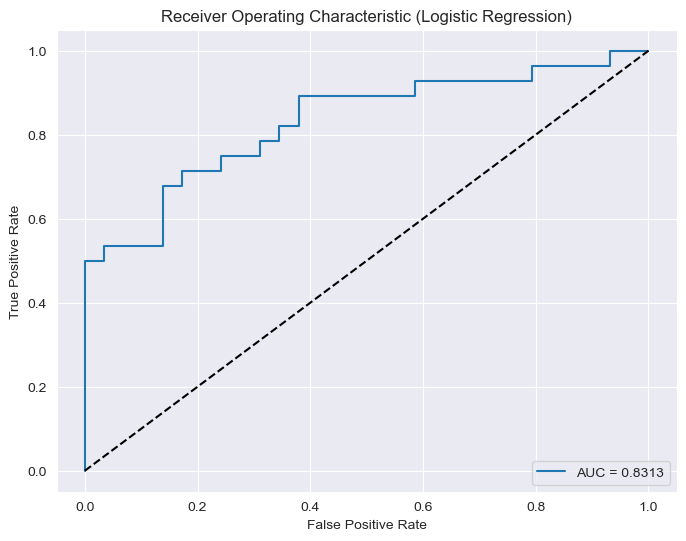

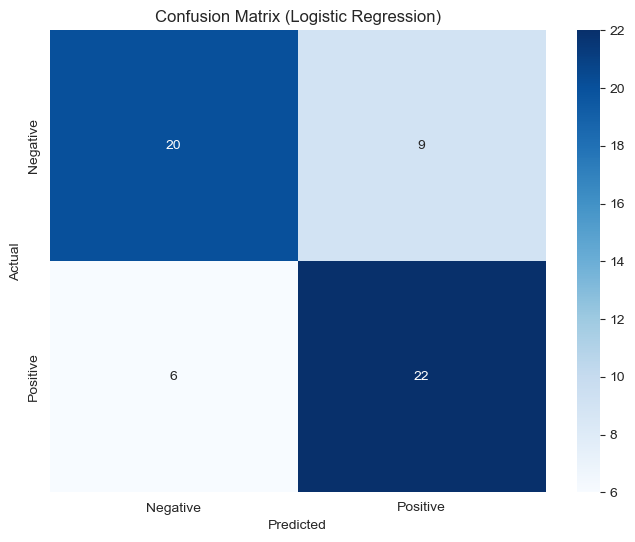

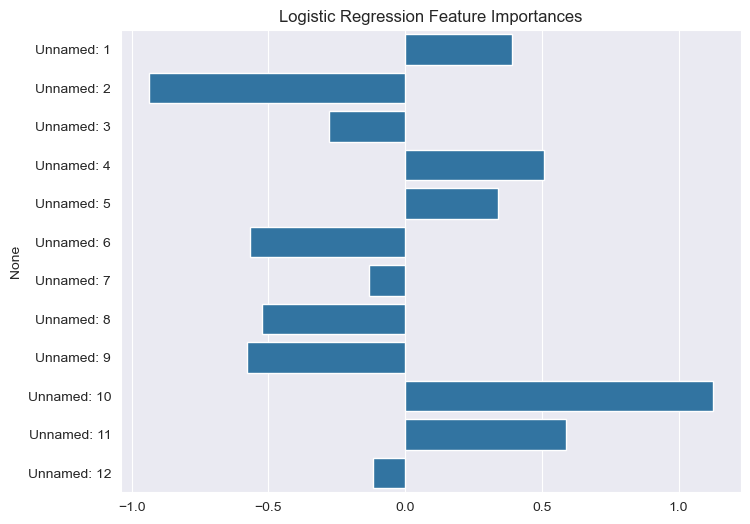

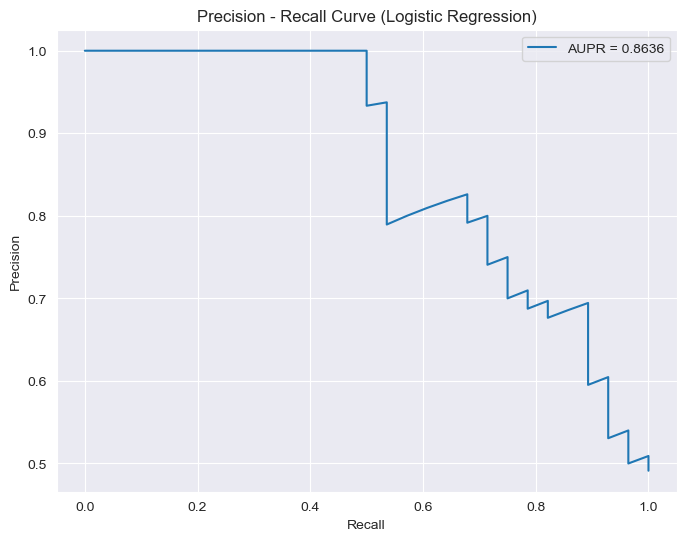

In [1]:
"""
LR
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE


df = pd.read_excel('data5.xlsx')
df.fillna(0, inplace=True)


X = df.iloc[:, 1:]
y = np.where(df.iloc[:, 0] == 'sick', 1, 0)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


xtrain, xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)


lr = LogisticRegression(random_state=42)
param_grid_lr = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2']
}
grid_lr = GridSearchCV(lr, param_grid_lr, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_lr.fit(xtrain, ytrain)
best_lr = grid_lr.best_estimator_


y_pred_proba = best_lr.predict_proba(xtest)[:, 1]
y_pred = best_lr.predict(xtest)

print("Logistic Regression Test AUC:", roc_auc_score(ytest, y_pred_proba))
print("Logistic Regression Accuracy:", accuracy_score(ytest, y_pred))


fpr, tpr, _ = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = %0.4f' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()


cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()


plt.figure(figsize=(8, 6))
sns.barplot(x=best_lr.coef_[0], y=X.columns)
plt.title("Logistic Regression Feature Importances")
plt.show()


precision, recall, _ = precision_recall_curve(ytest, y_pred_proba)
aupr = average_precision_score(ytest, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='AUPR = %0.4f' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve (Logistic Regression)')
plt.legend(loc="upper right")
plt.show()

Ensemble Test AUC: 0.9421182266009853
Ensemble Accuracy: 0.9473684210526315


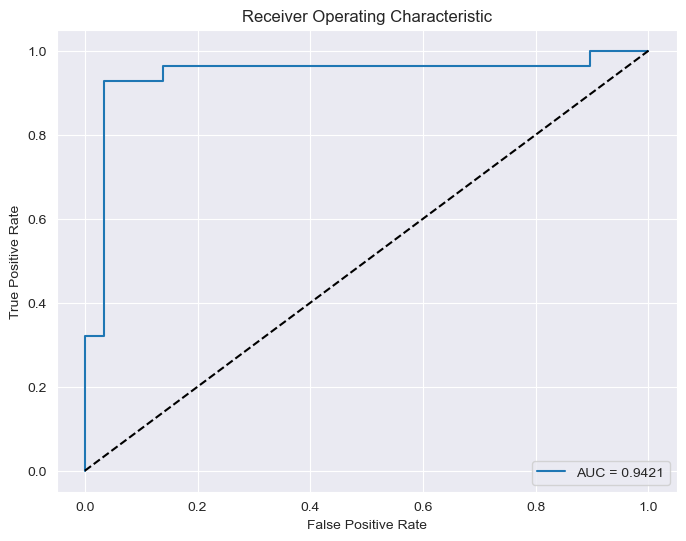

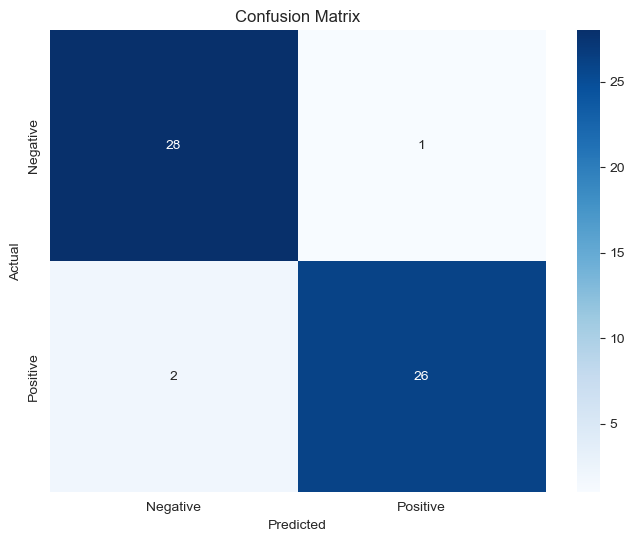

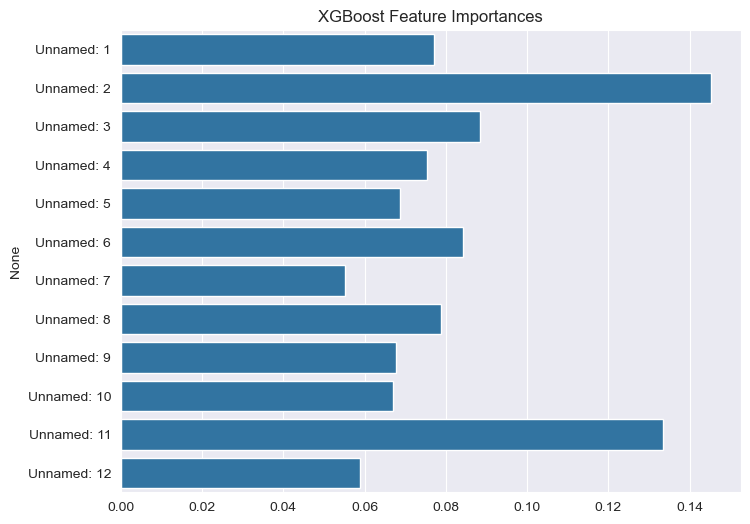

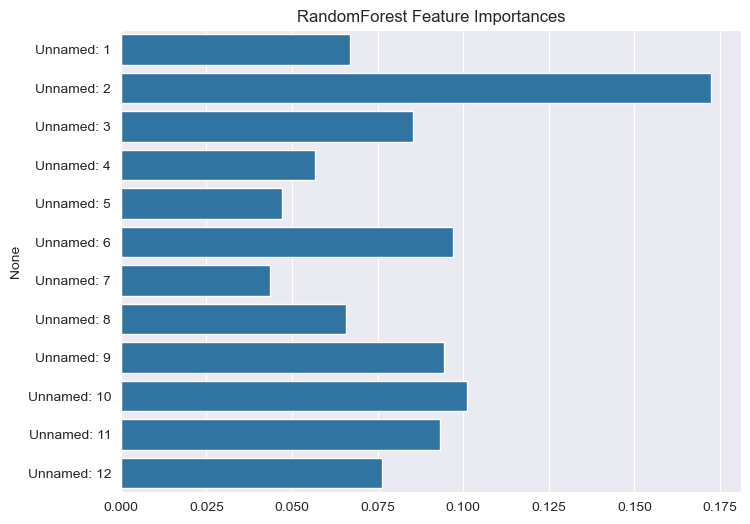

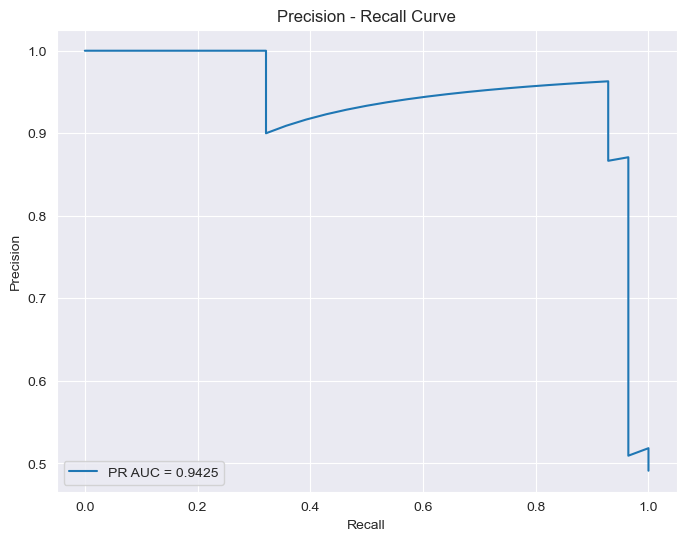

In [2]:
"""
new ensemble(XGBoost & RF)
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE  


df = pd.read_excel('data5.xlsx')
df.fillna(0, inplace=True)


X = df.iloc[:, 1:]
y = np.where(df.iloc[:, 0] == 'sick', 1, 0)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


xtrain, xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)


xgb = XGBClassifier(random_state=42, eval_metric='logloss')  # 移除 use_label_encoder 参数
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_xgb.fit(xtrain, ytrain)
best_xgb = grid_xgb.best_estimator_


rfc = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
grid_rf = GridSearchCV(rfc, param_grid_rf, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_rf.fit(xtrain, ytrain)
best_rfc = grid_rf.best_estimator_


ensemble_model = VotingClassifier(estimators=[('xgb', best_xgb), ('rf', best_rfc)], voting='soft')
ensemble_model.fit(xtrain, ytrain)


y_pred_proba = ensemble_model.predict_proba(xtest)[:, 1]
y_pred = ensemble_model.predict(xtest)

print("Ensemble Test AUC:", roc_auc_score(ytest, y_pred_proba))
print("Ensemble Accuracy:", accuracy_score(ytest, y_pred))


fpr, tpr, _ = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = %0.4f' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


plt.figure(figsize=(8, 6))
sns.barplot(x=best_xgb.feature_importances_, y=X.columns)
plt.title("XGBoost Feature Importances")
plt.show()


plt.figure(figsize=(8, 6))
sns.barplot(x=best_rfc.feature_importances_, y=X.columns)
plt.title("RandomForest Feature Importances")
plt.show()


precision, recall, _ = precision_recall_curve(ytest, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR AUC = %0.4f' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.legend(loc="lower left")
plt.show()

Random Forest Test AUC: 0.9427339901477834
Random Forest Accuracy: 0.9122807017543859


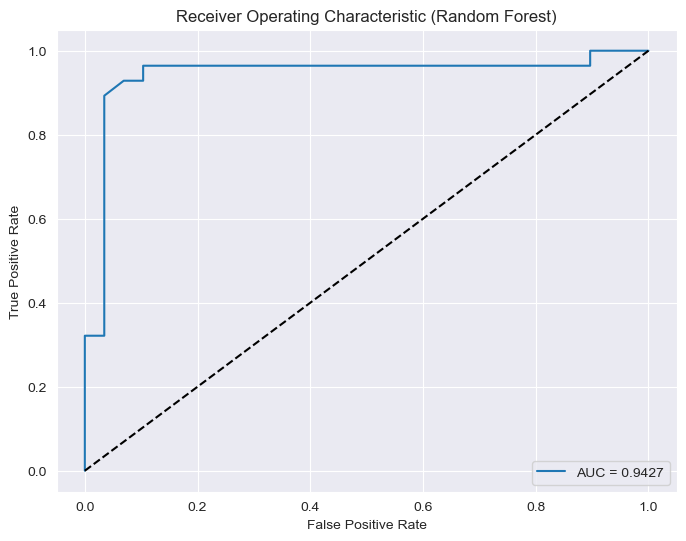

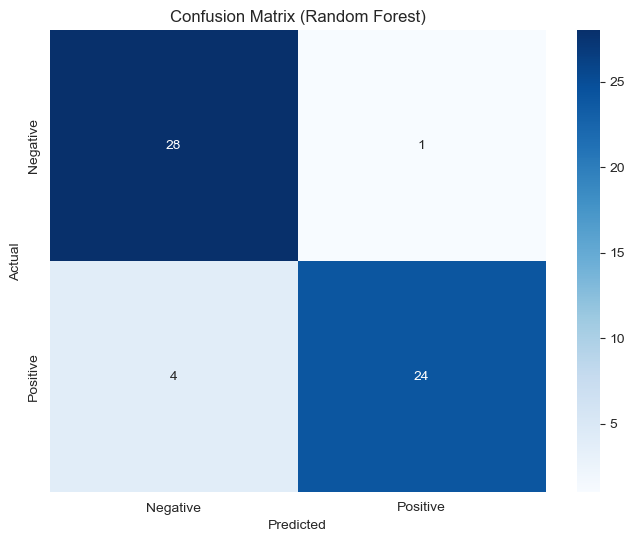

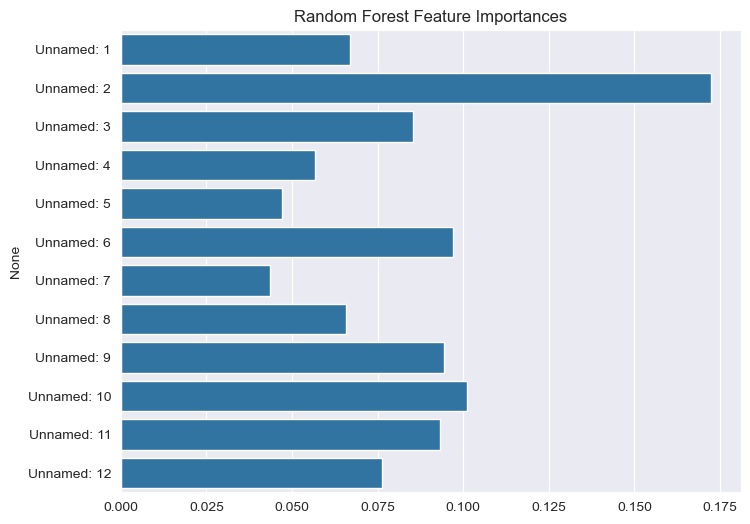

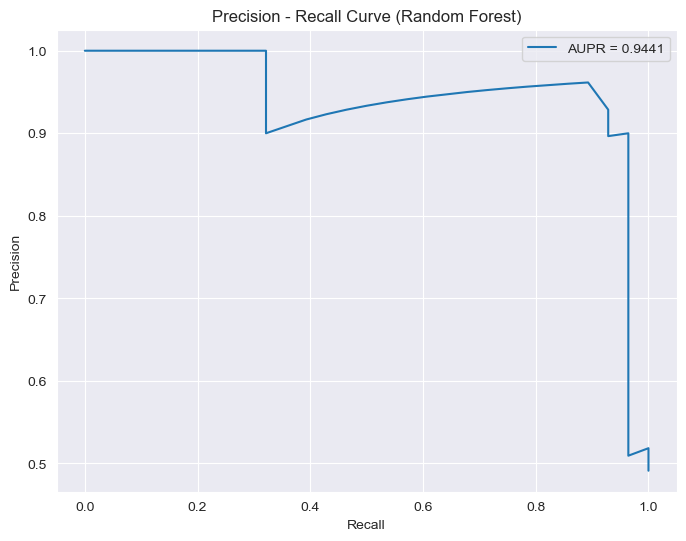

In [3]:
"""
RF
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE


df = pd.read_excel('data5.xlsx')
df.fillna(0, inplace=True)


X = df.iloc[:, 1:]
y = np.where(df.iloc[:, 0] == 'sick', 1, 0)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


xtrain, xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)


rfc = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
grid_rf = GridSearchCV(rfc, param_grid_rf, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_rf.fit(xtrain, ytrain)
best_rfc = grid_rf.best_estimator_


y_pred_proba = best_rfc.predict_proba(xtest)[:, 1]
y_pred = best_rfc.predict(xtest)

print("Random Forest Test AUC:", roc_auc_score(ytest, y_pred_proba))
print("Random Forest Accuracy:", accuracy_score(ytest, y_pred))


fpr, tpr, _ = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = %0.4f' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Random Forest)')
plt.legend(loc="lower right")
plt.show()


cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()


plt.figure(figsize=(8, 6))
sns.barplot(x=best_rfc.feature_importances_, y=X.columns)
plt.title("Random Forest Feature Importances")
plt.show()


precision, recall, _ = precision_recall_curve(ytest, y_pred_proba)
aupr = average_precision_score(ytest, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='AUPR = %0.4f' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve (Random Forest)')
plt.legend(loc="upper right")
plt.show()

SVM Test AUC: 0.958128078817734
SVM Accuracy: 0.8421052631578947


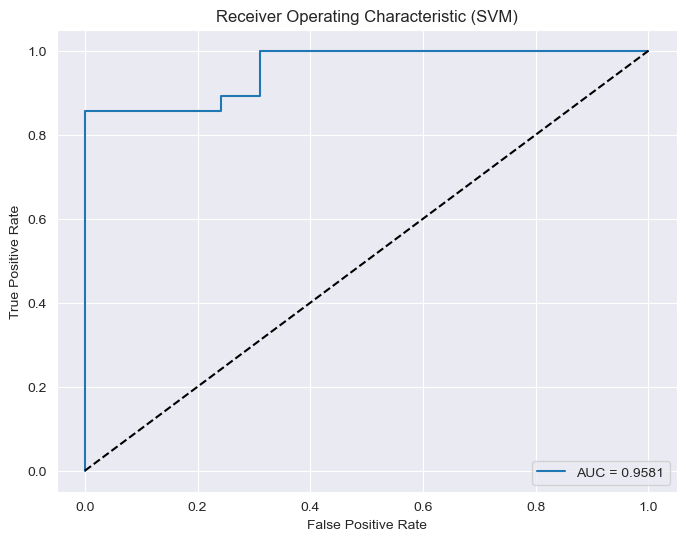

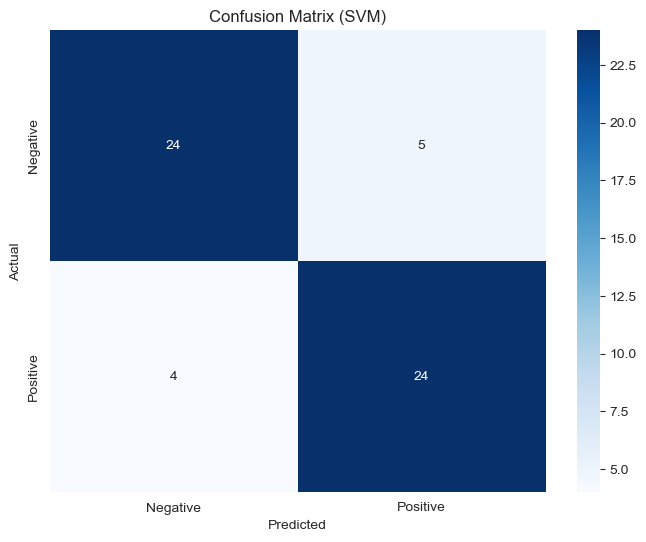

The SVM did not use a linear kernel, so a feature importance plot cannot be generated.


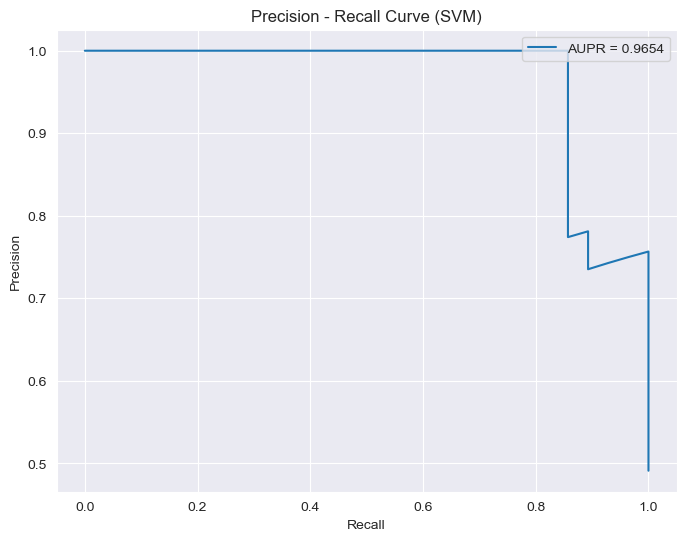

In [4]:
"""
SVM
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE


df = pd.read_excel(r'data5.xlsx')
df.fillna(0, inplace=True)


X = df.iloc[:, 1:]
y = np.where(df.iloc[:, 0] == 'sick', 1, 0)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


xtrain, xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)


svm = SVC(random_state=42, probability=True)
kernels = ['linear', 'rbf', 'poly']
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': kernels,
    'degree': [2, 3, 4] if 'poly' in kernels else []
}
grid_svm = GridSearchCV(svm, param_grid_svm, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_svm.fit(xtrain, ytrain)
best_svm = grid_svm.best_estimator_


y_pred_proba = best_svm.predict_proba(xtest)[:, 1]
y_pred = best_svm.predict(xtest)

print("SVM Test AUC:", roc_auc_score(ytest, y_pred_proba))
print("SVM Accuracy:", accuracy_score(ytest, y_pred))


fpr, tpr, _ = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = %0.4f' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (SVM)')
plt.legend(loc="lower right")
plt.show()


cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()


if best_svm.kernel == 'linear':
    plt.figure(figsize=(8, 6))
    sns.barplot(x=best_svm.coef_[0], y=X.columns)
    plt.title("SVM Feature Importances (Linear Kernel)")
    plt.show()
else:
    print(f"The SVM did not use a linear kernel, so a feature importance plot cannot be generated.")


precision, recall, _ = precision_recall_curve(ytest, y_pred_proba)
aupr = average_precision_score(ytest, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='AUPR = %0.4f' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve (SVM)')
plt.legend(loc="upper right")
plt.show()

XGBoost Test AUC: 0.937192118226601
XGBoost Accuracy: 0.8947368421052632


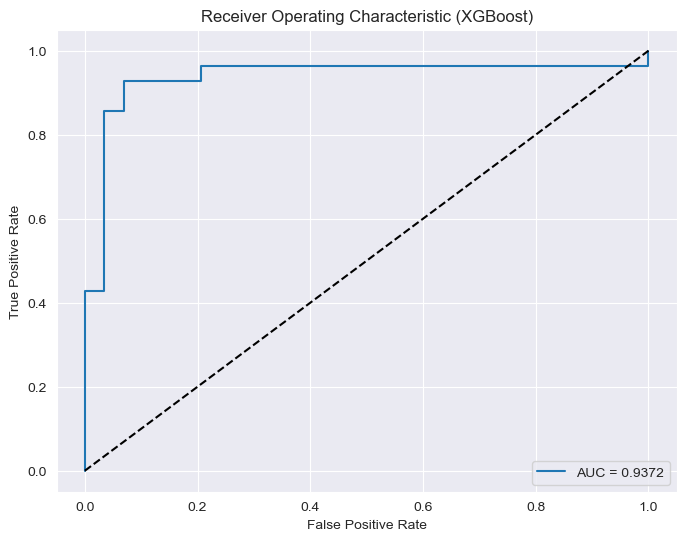

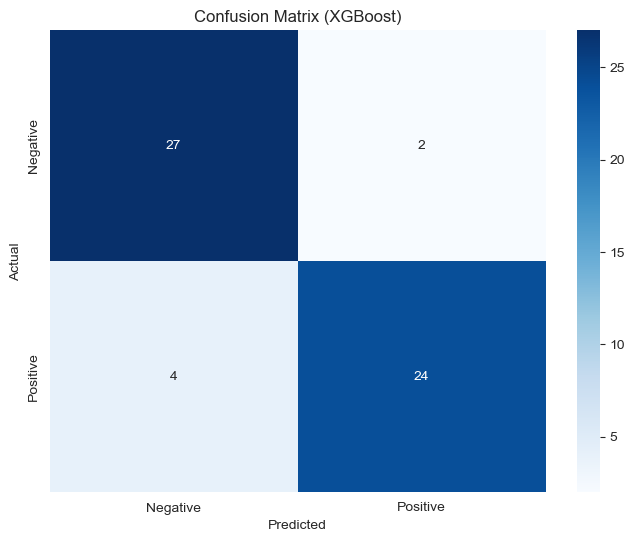

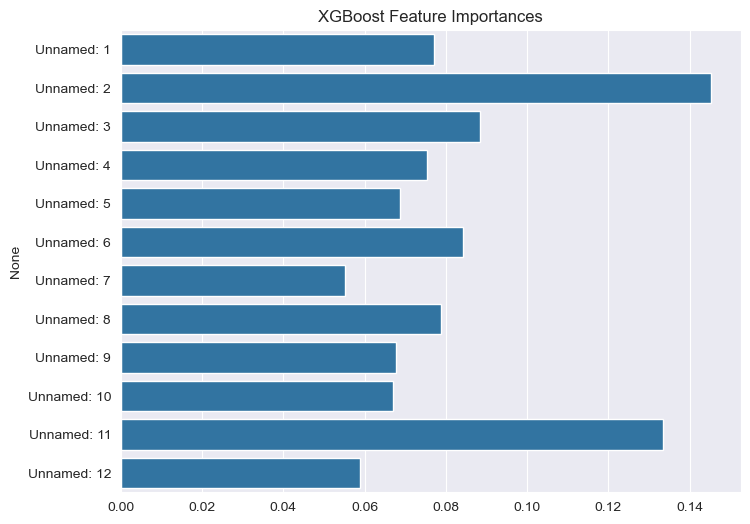

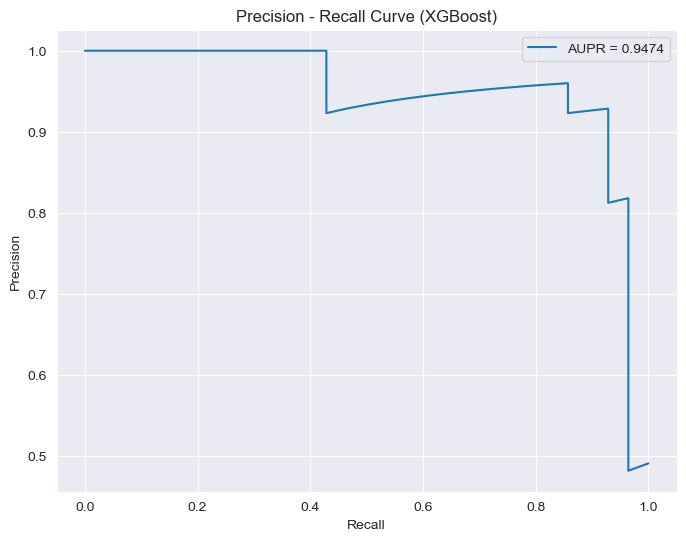

In [5]:
"""
XGBoost
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE


df = pd.read_excel('data5.xlsx')
df.fillna(0, inplace=True)


X = df.iloc[:, 1:]
y = np.where(df.iloc[:, 0] == 'sick', 1, 0)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


xtrain, xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)


xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_xgb.fit(xtrain, ytrain)
best_xgb = grid_xgb.best_estimator_


y_pred_proba = best_xgb.predict_proba(xtest)[:, 1]
y_pred = best_xgb.predict(xtest)

print("XGBoost Test AUC:", roc_auc_score(ytest, y_pred_proba))
print("XGBoost Accuracy:", accuracy_score(ytest, y_pred))


fpr, tpr, _ = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = %0.4f' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (XGBoost)')
plt.legend(loc="lower right")
plt.show()


cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()


plt.figure(figsize=(8, 6))
sns.barplot(x=best_xgb.feature_importances_, y=X.columns)
plt.title("XGBoost Feature Importances")
plt.show()


precision, recall, _ = precision_recall_curve(ytest, y_pred_proba)
aupr = average_precision_score(ytest, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='AUPR = %0.4f' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve (XGBoost)')
plt.legend(loc="upper right")
plt.show()

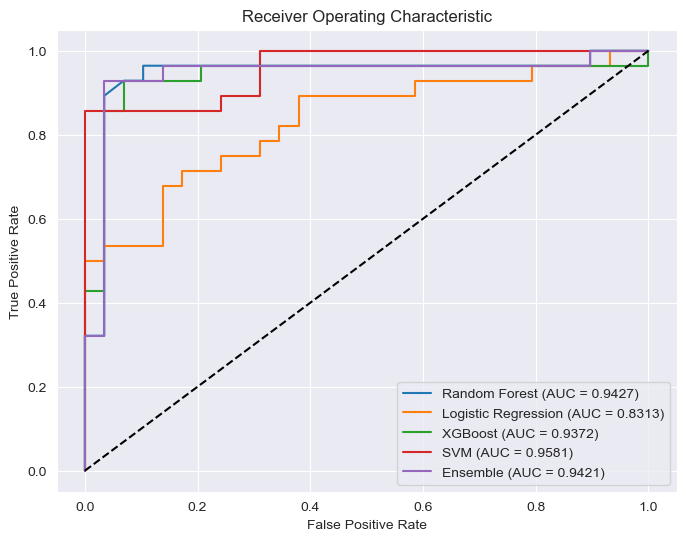

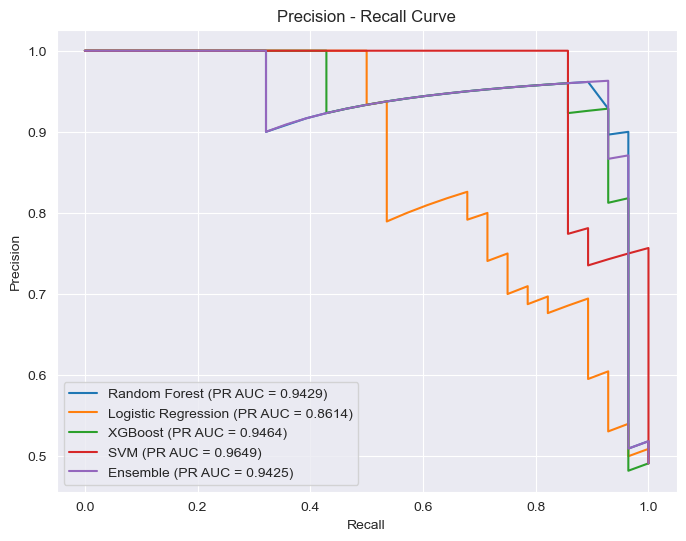

In [6]:
"""
compare
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE  


df = pd.read_excel('data5.xlsx')
df.fillna(0, inplace=True)


X = df.iloc[:, 1:]
y = np.where(df.iloc[:, 0] == 'sick', 1, 0)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


xtrain, xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)


xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_xgb.fit(xtrain, ytrain)
best_xgb = grid_xgb.best_estimator_


rfc = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
grid_rf = GridSearchCV(rfc, param_grid_rf, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_rf.fit(xtrain, ytrain)
best_rfc = grid_rf.best_estimator_


lr = LogisticRegression(random_state=42)
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(lr, param_grid_lr, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_lr.fit(xtrain, ytrain)
best_lr = grid_lr.best_estimator_


svm = SVC(random_state=42, probability=True)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
grid_svm = GridSearchCV(svm, param_grid_svm, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1)
grid_svm.fit(xtrain, ytrain)
best_svm = grid_svm.best_estimator_


ensemble_model = VotingClassifier(estimators=[('xgb', best_xgb), ('rf', best_rfc)], voting='soft')
ensemble_model.fit(xtrain, ytrain)


models = {
    'Random Forest': best_rfc,
    'Logistic Regression': best_lr,
    'XGBoost': best_xgb,
    'SVM': best_svm,
    'Ensemble': ensemble_model
}


plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(xtest)[:, 1]
    fpr, tpr, _ = roc_curve(ytest, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(xtest)[:, 1]
    precision, recall, _ = precision_recall_curve(ytest, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (PR AUC = {pr_auc:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.legend(loc="lower left")
plt.show()